# Steam Game Recommendation System

In this notebook, we'll explore the realm of game recommendations within Steam, the leading digital distribution platform for PC gaming. Our main objective is to construct a robust recommendation system utilizing collaborative filtering, content-based filtering, and a hybrid approach merging both methods, along with association rule mining.

This streamlined recommendation system aims to enrich user interaction on the platform by delivering tailored game recommendations derived from their preferences and those of comparable users.


# Importing Dependencies

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime as dt
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Preparation:
In this section, three datasets: games, users, and recommendations are loaded and processed. The data is also chunked to manage memory effectively using generator functions

In [79]:
# Function to reduce the memory usage of a DataFrame.
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

# Generator function to load data in chunks.
def data_generator(df, chunksize=10000):
    for i in range(0, df.shape[0], chunksize):
        yield df.iloc[i:i+chunksize]
        
# Load data
games_df = reduce_memory(pd.read_csv(r'games.csv'))
users_df = reduce_memory(pd.read_csv(r'users.csv'))
recommendations_df = reduce_memory(pd.read_csv(r'recommendations.csv'))

In [80]:
games_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,21-11-2008,True,False,False,Very Positive,84,2199,9.99,9.99,0,True
1,22364,BRINK: Agents of Change,03-08-2011,True,False,False,Positive,85,21,2.99,2.99,0,True
2,113020,Monaco: What's Yours Is Mine,24-04-2013,True,True,True,Very Positive,92,3722,14.99,14.99,0,True
3,226560,Escape Dead Island,18-11-2014,True,False,False,Mixed,61,873,14.99,14.99,0,True
4,249050,Dungeon of the ENDLESS™,27-10-2014,True,True,False,Very Positive,88,8784,11.99,11.99,0,True


In [81]:
users_df.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [82]:
recommendations_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,12-12-2022,True,36.299999,51580,0
1,304390,4,0,17-02-2017,False,11.500000,2586,1
2,1085660,2,0,17-11-2019,True,336.500000,253880,2
3,703080,0,0,23-09-2022,True,27.400000,259432,3
4,526870,0,0,10-01-2021,True,7.900000,23869,4


# Exploratory Data Analysis
Exploratory data analysis (EDA) in a game recommendation system project is essential for understanding dataset characteristics, user preferences, and interaction patterns. By exploring data distributions and trends, we identify relevant features and variables for recommendation algorithms. This analysis guides us in refining and optimizing the system for improved performance and user satisfaction.

In [83]:
# Games Data
games_df.shape

(50872, 13)

In [84]:
games_df.dtypes

app_id              int32
title              object
date_release       object
win                  bool
mac                  bool
linux                bool
rating             object
positive_ratio      int32
user_reviews        int32
price_final       float32
price_original    float32
discount            int32
steam_deck           bool
dtype: object

In [85]:
# Converting  the date_release columns to Datatime object
games_df['date_release']=pd.to_datetime(games_df['date_release'])

In [86]:
games_df.dtypes

app_id                     int32
title                     object
date_release      datetime64[ns]
win                         bool
mac                         bool
linux                       bool
rating                    object
positive_ratio             int32
user_reviews               int32
price_final              float32
price_original           float32
discount                   int32
steam_deck                  bool
dtype: object

In [87]:
games_df.describe(include='all')

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
count,5.087200e+04,50872,50872,50872,50872,50872,50872,50872.000000,5.087200e+04,50872.000000,50872.000000,50872.000000,50872
unique,NaN,50751,NaN,2,2,2,9,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Loop,NaN,True,False,False,Positive,NaN,NaN,NaN,NaN,NaN,True
freq,NaN,4,NaN,50076,37854,41831,13502,NaN,NaN,NaN,NaN,NaN,50870
mean,1.055224e+06,NaN,2019-03-13 03:53:57.112753664,NaN,NaN,NaN,NaN,77.052033,1.824425e+03,8.620325,8.726789,5.592212,NaN
min,1.000000e+01,NaN,1997-06-30 00:00:00,NaN,NaN,NaN,NaN,0.000000,1.000000e+01,0.000000,0.000000,0.000000,NaN
25%,5.287375e+05,NaN,2017-03-21 00:00:00,NaN,NaN,NaN,NaN,67.000000,1.900000e+01,0.990000,0.990000,0.000000,NaN
50%,9.860850e+05,NaN,2019-08-23 00:00:00,NaN,NaN,NaN,NaN,81.000000,4.900000e+01,4.990000,4.990000,0.000000,NaN
75%,1.524895e+06,NaN,2021-09-21 00:00:00,NaN,NaN,NaN,NaN,91.000000,2.060000e+02,10.990000,11.990000,0.000000,NaN
max,2.599300e+06,NaN,2023-10-24 00:00:00,NaN,NaN,NaN,NaN,100.000000,7.494460e+06,299.989990,299.989990,90.000000,NaN


In [88]:
games_df.isnull().sum()

app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64

In [89]:
games_df.columns

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck'],
      dtype='object')

In [90]:
games_df['win'].value_counts()

win
True     50076
False      796
Name: count, dtype: int64

In [91]:
games_df['mac'].value_counts()

mac
False    37854
True     13018
Name: count, dtype: int64

In [92]:
games_df['linux'].value_counts()

linux
False    41831
True      9041
Name: count, dtype: int64

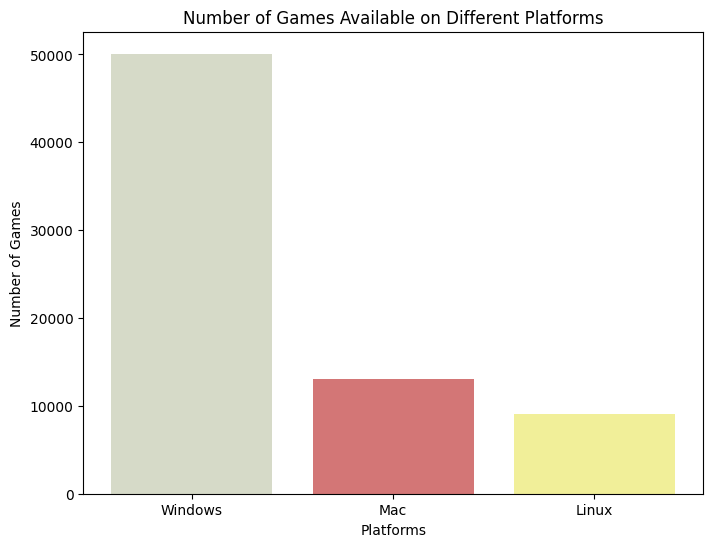

In [93]:
# Data
platforms = ['Windows', 'Mac', 'Linux']
num_games = [50076, 13018, 9041]  # Replace these with actual counts

# Create bar plot
plt.figure(figsize=(8, 6))
custom_palette = ['#D6DAC8', '#D37676', '#F1EF99']
plt.bar(platforms, num_games, color=custom_palette)
plt.xlabel('Platforms')
plt.ylabel('Number of Games')
plt.title('Number of Games Available on Different Platforms')
plt.show()

Create a bar plot to compare the number of games available on Windows, Mac, and Linux platforms, providing insights into platform compatibility. Where we can see that most of the games are available only for the Windows platform

In [94]:
unique_ratings = games_df['rating'].unique()

print("Unique ratings:", unique_ratings)

Unique ratings: ['Very Positive' 'Positive' 'Mixed' 'Mostly Positive'
 'Overwhelmingly Positive' 'Negative' 'Mostly Negative'
 'Overwhelmingly Negative' 'Very Negative']


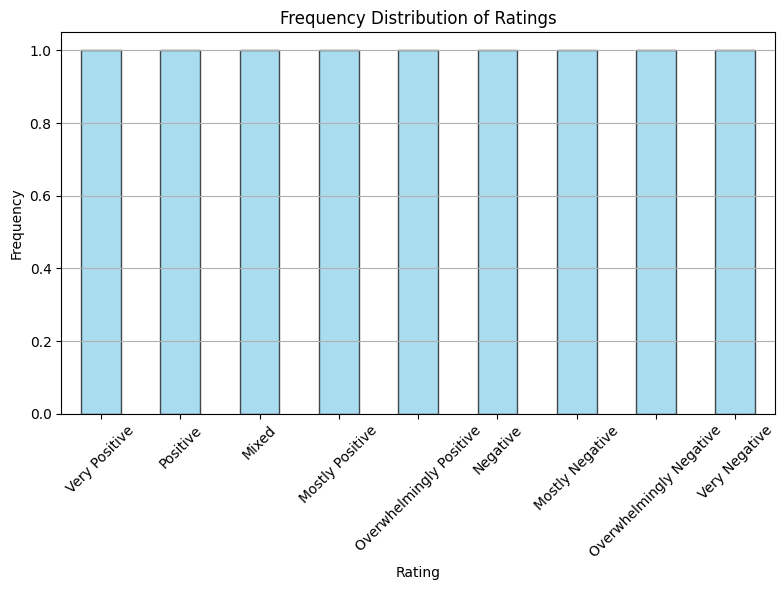

In [95]:
# Sample ratings data (replace with actual ratings data)
ratings = ['Very Positive', 'Positive', 'Mixed', 'Mostly Positive',
 'Overwhelmingly Positive','Negative','Mostly Negative','Overwhelmingly Negative','Very Negative']

# Convert ratings to a Pandas Series
ratings_series = pd.Series(ratings)

# Calculate frequency of each rating
rating_counts = ratings_series.value_counts()

# Create bar plot
plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Ratings')
plt.xticks(rotation=45) 
plt.grid(axis='y')  
plt.tight_layout()  
plt.show()

Visualize the distribution of game ratings using a histogram to understand the frequency distribution of different rating values' write a code for this

In [96]:
# Users Data
users_df.shape

(14306064, 3)

In [97]:
users_df.dtypes

user_id     int32
products    int32
reviews     int32
dtype: object

In [98]:
users_df.describe(include='all')

,user_id,products,reviews
count,1.430606e+07,1.430606e+07,1.430606e+07
mean,7.153032e+06,1.163734e+02,2.876738e+00
std,4.129805e+06,2.438515e+02,7.987421e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.576516e+06,2.300000e+01,1.000000e+00
50%,7.153032e+06,5.500000e+01,1.000000e+00
75%,1.072955e+07,1.270000e+02,3.000000e+00
max,1.430606e+07,3.221400e+04,6.045000e+03


In [99]:
users_df.isnull().sum()

user_id     0
products    0
reviews     0
dtype: int64

In [100]:
users_df.columns

Index(['user_id', 'products', 'reviews'], dtype='object')

In [101]:
# Recommendations Data
recommendations_df.shape

(1048575, 8)

In [102]:
recommendations_df.dtypes

app_id              int32
helpful             int32
funny               int32
date               object
is_recommended       bool
hours             float32
user_id             int32
review_id           int32
dtype: object

In [103]:
# Converting  the date_release columns to Datatime object
# recommendations_df['date']=pd.to_datetime(recommendations_df['date'])

In [104]:
recommendations_df.dtypes

app_id              int32
helpful             int32
funny               int32
date               object
is_recommended       bool
hours             float32
user_id             int32
review_id           int32
dtype: object

In [105]:
recommendations_df.describe(include='all')

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
count,1.048575e+06,1.048575e+06,1.048575e+06,1048575,1048575,1.048575e+06,1.048575e+06,1.048575e+06
unique,NaN,NaN,NaN,4061,2,NaN,NaN,NaN
top,NaN,NaN,NaN,22-11-2022,True,NaN,NaN,NaN
freq,NaN,NaN,NaN,5760,886223,NaN,NaN,NaN
mean,6.196774e+05,3.344574e+00,1.142080e+00,NaN,NaN,2.012187e+02,7.273806e+06,5.242870e+05
std,5.058972e+05,5.968650e+01,3.412487e+01,NaN,NaN,2.368035e+02,4.086430e+06,3.026977e+05
min,4.400000e+02,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00,2.000000e+00,0.000000e+00
25%,2.557100e+05,0.000000e+00,0.000000e+00,NaN,NaN,3.090000e+01,3.842548e+06,2.621435e+05
50%,3.943600e+05,0.000000e+00,0.000000e+00,NaN,NaN,1.003000e+02,7.212169e+06,5.242870e+05
75%,1.091500e+06,0.000000e+00,0.000000e+00,NaN,NaN,2.850000e+02,1.109478e+07,7.864305e+05


In [106]:
recommendations_df.isnull().sum()

app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64

In [107]:
recommendations_df.columns

Index(['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id', 'review_id'],
      dtype='object')

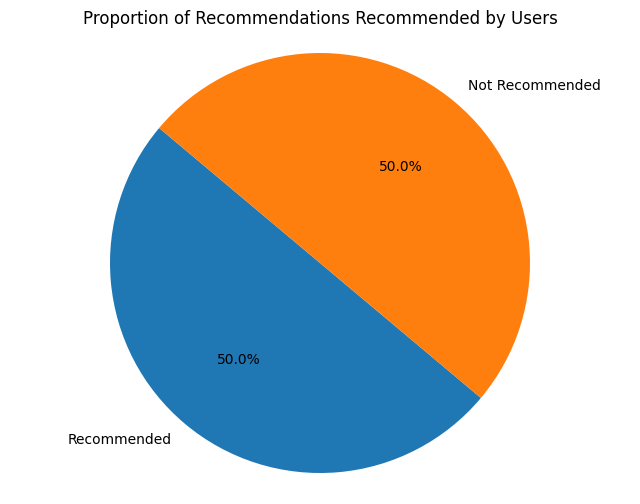

In [108]:
recommendations = ['true','false']

# Count the number of recommendations
recommended_count = recommendations.count('true')
not_recommended_count = recommendations.count('false')

# Create labels and sizes for the pie chart
labels = ['Recommended', 'Not Recommended']
sizes = [recommended_count, not_recommended_count]

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Recommendations Recommended by Users')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

Using a pie chart to visualize the proportion of recommendations that are recommended by users vs. not recommended. This will provide an overview of user sentiment towards recommendations and we can see that there is a ratio of 1:1 in the recommended and not recommended class

# Model Building

## Collaborative Filtering
Here, a user-user collaborative filtering model is built using K-Nearest Neighbors (KNN). This model recommends users who are similar to a given user

In [109]:
from scipy.sparse import coo_matrix

# map each user and item to a unique numeric value
user_ids = recommendations_df['user_id'].astype('category').cat.codes
item_ids = recommendations_df['app_id'].astype('category').cat.codes

# Get the unique user and game ids
unique_user_ids = recommendations_df['user_id'].astype('category').cat.categories
unique_item_ids = recommendations_df['app_id'].astype('category').cat.categories

# create a sparse matrix
user_game_matrix = coo_matrix((recommendations_df['hours'], (user_ids, item_ids)))

# Fit the model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_game_matrix)

# Get top 5 recommendations for first user
distances, indices = model_knn.kneighbors(user_game_matrix.getrow(0), n_neighbors=6)
recommended_users = [unique_user_ids[i] for i in indices.flatten()[1:]]
print(f'Recommended users for the first user are: {recommended_users}')

Recommended users for the first user are: [8373299, 9315434, 2293282, 13539268, 346241]


## Content-Based Filtering
This section involves the construction of a content-based filtering model using TF-IDF vectorizer and cosine similarity. It recommends games that are similar to a given game based on their descriptions

In [117]:
# Content-Based Filtering
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(games_df['title'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Get top 5 recommendations for first game
similar_indices = cosine_similarities[0].argsort()[:-6:-1]
recommended_games = [games_df['title'].iloc[i] for i in similar_indices]
print(f'Recommended games for the first game are: {recommended_games}')

TypeError: no supported conversion for types: (dtype('O'),)

## Hybrid System
This section combines the collaborative and content-based filtering models to create a hybrid recommender system. It recommends games to a user that are liked by similar users and are also similar in content to the games the user likes.

In [72]:
import numpy as np

def get_similar_users(user_id, user_game_matrix, model_knn, n_neighbors=6):
    distances, indices = model_knn.kneighbors(user_game_matrix.getrow(user_id), n_neighbors=n_neighbors)
    similar_users = [unique_user_ids[i] for i in indices.flatten()[1:]]
    return similar_users

# Get the unique game ids
unique_game_ids = recommendations_df['app_id'].astype('category').cat.categories

def get_similar_games(game_id, tfidf_matrix, n_neighbors=6):
    # Find the positional index of the game_id
    game_index = np.where(unique_game_ids == game_id)[0][0]
    
    cosine_similarities = linear_kernel(tfidf_matrix[game_index], tfidf_matrix).flatten()
    similar_indices = cosine_similarities.argsort()[:-n_neighbors:-1]
    similar_games = [games_df['title'].iloc[i] for i in similar_indices]
    return similar_games

def recommend_games(user_id):
    similar_users = get_similar_users(user_id, user_game_matrix, model_knn)
    similar_games = []
    for user in similar_users:
        user_games = recommendations_df[recommendations_df['user_id'] == user]['app_id'].unique()
        for game_id in user_games:
            similar_games.extend(get_similar_games(game_id, tfidf_matrix))
    unique_game_titles = list(set(similar_games))
    return unique_game_titles

In [73]:
recommend_games(726603)

['Horror Bar VR',
 'High School Odyssey',
 'Mission in Snowdriftland',
 'FatalZone',
 'Pinball FX3 - Williams™ Pinball: Volume 6']

In [59]:
import pickle

pickle.dump(games_df,open('CP2Dep/Game_df.pkl','wb'))
pickle.dump(users_df,open('CP2Dep/User_df.pkl','wb'))
pickle.dump(recommendations_df,open('CP2Dep/Recommendation_df.pkl','wb'))
pickle.dump(cosine_similarities,open('CP2Dep/similarity.pkl','wb'))

MemoryError: 